In [1]:
from pylearn2.utils import serial
from pylearn2.config import yaml_parse
from pylearn2.datasets import ecog
from pylearn2.space import VectorSpace, Conv2DSpace, CompositeSpace
from pylearn2.expr import nnet

import os, h5py, theano, cPickle
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as T
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import analysis

Using gpu device 0: Tesla K40c


# Get Files

In [23]:
cv_dim = 57
model_folders = ["exps/two_headed/"]
model_file_base = ".pkl"
files = [sorted([f for f in os.listdir(model_folder) if ((model_file_base in f) and ('.pkl' in f))])
         for model_folder in model_folders]
print files

[['22_fold0.pkl', '22_fold1.pkl', '22_fold2.pkl', '22_fold3.pkl', '22_fold4.pkl', '22_fold5.pkl', '22_fold6.pkl', '22_fold7.pkl', '22_fold8.pkl', '22_fold9.pkl']]


# Collect Statistics

### Full Classification

In [4]:
kwargs = {'move': .1,
          'center': True,
          'level_classes': True,
          'consonant_prediction': False,
          'vowel_prediction': False,
          'two_headed': True,
          'randomize_labels': False,
          'audio': False}
accuracy_dicts = []
indices_dicts = []
y_hat_dicts = []
for file_list in files:
    accuracy_dict = {}
    accuracy_dicts.append(accuracy_dict)
    indices_dict = {}
    indices_dicts.append(indices_dict)
    y_hat_dict = {}
    y_hat_dicts.append(y_hat_dict)
    for ii, filename in enumerate(file_list):
        misclass, indices, y_hat = analysis.get_model_results(model_folder, filename, ii, kwargs)
        accuracy_dict[filename] = [1.-m for m in misclass]
        indices_dict[filename] = indices
        y_hat_dict[filename] = y_hat
y_dims = None
for yd in y_hat_dicts:
    for key in yd.keys():
        ydim = (yd[key][0].shape[1], yd[key][1].shape[1])
        if y_dims == None:
            y_dims = ydim
        else:
            assert y_dims == ydim

In [15]:
c_mat, v_mat, cv_mat = analysis.dict2mat(indices_dicts, y_dims)
c_accuracy = None
v_accuracy = None
cv_accuracy = None
accuracy_per_cv = None

if cv_mat is not None:
    cv_accuracy = np.zeros(len(cv_mat))
    accuracy_per_cv = np.zeros((len(cv_mat), 57))
    for ii, cvf in enumerate(cv_mat):
        cv_accuracy[ii] = np.diag(cvf).sum()/cvf.sum()
        for jj in range(57):
            accuracy_per_cv[ii,jj] = cvf[jj,jj]/cvf[jj].sum()
    print 'cv mean: ',cv_accuracy.mean()
    print 'cv std: ',cv_accuracy.std()
if c_mat is not None:
    c_accuracy = np.zeros(len(c_mat))
    for ii, cf in enumerate(c_mat):
        c_accuracy[ii] = np.diag(cf).sum()/cf.sum()
    print 'c mean: ',c_accuracy.mean()
    print 'c std: ',c_accuracy.std()
if v_mat is not None:
    v_accuracy = np.zeros(len(v_mat))
    for ii, vf in enumerate(v_mat):
        v_accuracy[ii] = np.diag(vf).sum()/vf.sum()
    print 'v mean: ',v_accuracy.mean()
    print 'v std: ',v_accuracy.std()

cv mean:  0.354198473282
cv std:  0.0283985881492
c mean:  0.45572519084
c std:  0.0256152087566
v mean:  0.770229007634
v std:  0.0150557884911


In [52]:
from scipy.stats import wilcoxon
print wilcoxon(np.array(CV_rand_accuracy.values()), np.array(accuracy_dict.values()))

(0.0, 0.0050620321262678644)


In [55]:
accuracy_dict.values()

[0.01526719331741333,
 0.01526719331741333,
 0.026717543601989746,
 0.0038167834281921387,
 0.0076335668563842773,
 0.011450409889221191,
 0.022900760173797607,
 0.030534327030181885,
 0.019083976745605469,
 0.01526719331741333]

In [51]:
CV_rand_accuracy.values()

[0.034351170063018799,
 0.057251930236816406,
 0.064885497093200684,
 0.061068713665008545,
 0.030534327030181885,
 0.057251930236816406,
 0.057251930236816406,
 0.045801520347595215,
 0.045801520347595215,
 0.038167953491210938]

In [ ]:
fc_aug 0.0050335082006062494
fc_lin 0.0050050744029052231
vowel 0.0050620321262678644
consonant 0.0050050744029052231
consonant lda 0.0050620321262678644

## LDA

In [49]:
kwargs = {'move': .1,
          'center': True,
          'level_classes': True,
          'consonant_prediction': True,
          'vowel_prediction': False}
accuracy_dict = {}
indices_dict = {}
y_hat_dict = {}
X_space = VectorSpace(dim=258*85)
for ii, file_name in enumerate(files):
    file_loc = os.path.join(model_folder, file_name)
    with open(file_loc) as f:
        model = cPickle.load(f)
    ds = ecog.ECoG('${PYLEARN2_DATA_PATH}/ecog/EC2_CV_85_nobaseline_aug.h5',
                   which_set='train',
                   fold=ii,
                   **kwargs)
    ts = ds.get_test_set()
    X = ts.X
    y = ts.y
    y_dim = y.shape[1]
    y = y.argmax(axis=1)
    indices = np.zeros((y.shape[0], 2))
    indices[:,1] = model.predict(X)
    indices[:,0] = y
    y_hat = model.predict_proba(X)
    accuracy = model.score(X, y)
    accuracy_dict[file_name] = accuracy
    indices_dict[file_name] = indices
    y_hat_dict[file_name] = y_hat

In [ ]:
fc = [.208396947384, .303435111046, .28015267849, .305725187063, .353053432703, .358396953344]
fc_std = [.0122137319297, .0274835709783, .0278495191188, .0308877472701, .0191030474981, .0339437379312]
cons = [.42213740458,.54465648855, .508396946565, .543511450382, .582061068702, .578244274809]
cons_std = [.0136766968452,.013445736606, .0223078461011, .0231034289319, .0206424691343, .0276947785247]
vowel = [.228244274809,.318320610687, .291603053435, .315267175573, .36106870229, .369465648855]
vowel_std = [.011551714466,.0274809160305, .0276921483164, .0315757524885, .023166398329, .0322874595154]

fc_lin = [.201526719332, .215648853779, .232442754507, .248091614246, .269083976746, .269847333431]
fc_lin_std = [.0212372934533, .0271636755767, .0257993736694, .0419152765516, .0272172467286, .0184671333416]
cons_lin = [.485114503817, .501526717557, .507633587786, .513358778626, .532824427481, .534351145038]
cons_lin_std = [.0205859336796, .0190992305392, .0301502559666, .031160095896, .0294264660571, .0215910467538]
vowel_lin = [.220610687023, .234732824427, .249618320611, .265648854962, .280916030534, .281679389313]
vowel_lin_std = [.0225029053023, .0268399595294, .0293769181754, .0451351007606, .0309701721757, .0220450825621]

### CV Classification

In [ ]:
kwargs = {'move': .1,
          'center': True,
          'level_classes': True,
          'consonant_prediction': False,
          'vowel_prediction': False}
accuracy_dict = {}
indices_dict = {}
X_space = VectorSpace(dim=258*85)
for fold in xrange(10):
    consonant_file_loc = os.path.join(consonant_folder, consonant_file_base+str(fold)+'.pkl')
    vowel_file_loc = os.path.join(vowel_folder, vowel_file_base+str(fold)+'.pkl')
    consonant_model = serial.load(consonant_file_loc)
    vowel_model = serial.load(vowel_file_loc)
    consonant = True
    for model in [consonant_model, vowel_model]:
        kwargs_copy = kwargs.copy()
        if consonant:
            kwargs_copy['consonant_prediction'] = True
        else:
            kwargs_copy['vowel_prediction'] = True
        X_sym = model.get_input_space().make_theano_batch()
        y_sym = model.get_target_space().make_theano_batch()
        input_space = model.get_input_space()
        ds = ecog.ECoG('${PYLEARN2_DATA_PATH}/ecog/EC2_CV_85_nobaseline_aug.h5',
                       which_set='train',
                       fold=fold,
                       **kwargs_copy)
        ts = ds.get_test_set()
        y_hat = model.fprop(X_sym)
        misclass_sym = nnet.Misclass(y_sym, y_hat)
        indices_sym = T.join(1, T.argmax(y_sym, axis=1, keepdims=True), T.argmax(y_hat, axis=1, keepdims=True))
        f = theano.function([X_sym, y_sym], [misclass_sym, indices_sym])
        it = ts.iterator(mode = 'sequential',
                         batch_size = ts.X.shape[0],
                         num_batches = 1,
                         data_specs = (CompositeSpace((model.get_input_space(),
                                                     model.get_target_space())),
                                       (model.get_input_source(), model.get_target_source())))
        X, y = it.next()
        misclass, indices = f(X, y)
        name = str(fold)
        if consonant:
            name = 'c_'+name
        else:
            name = 'v_'+name
        accuracy_dict[name] = 1.-misclass
        indices_dict[name] = indices
        consonant = False

In [ ]:
c_accuracy = np.zeros(10)
v_accuracy = np.zeros(10)
cv_accuracy = np.zeros(10)
cv_accuracy2 = np.zeros(10)
for fold in xrange(10):
    c_accuracy[fold] = accuracy_dict['c_'+str(fold)]
    v_accuracy[fold] = accuracy_dict['v_'+str(fold)]
    c_indices = indices_dict['c_'+str(fold)]
    v_indices = indices_dict['v_'+str(fold)]
    cv_indices = 3*c_indices+v_indices
    correct = (c_indices[:,0] == c_indices[:,1])*(v_indices[:,0] == v_indices[:,1])
    cv_accuracy[fold] = correct.mean()
    cv_accuracy2[fold] = (cv_indices[:,0] == cv_indices[:,1]).mean()

print 'consonants'
print 'mean: ',np.mean(c_accuracy)
print 'std: ',np.std(c_accuracy)
print 'vowels'
print 'mean: ',np.mean(v_accuracy)
print 'std: ',np.std(v_accuracy)
print 'cv'
print 'mean: ',np.mean(cv_accuracy)
print 'std: ',np.std(cv_accuracy)
print 'cv2'
print 'mean: ',np.mean(cv_accuracy2)
print 'std: ',np.std(cv_accuracy2)

## Make Confusion Matrices

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
rcParams['font.size'] = 18

with h5py.File('/home/jesse/Development/data/ecog/EC2_CV.h5', 'r') as f:
    ecog_E_lbls = f['Descriptors']['Event_ELbls'].value

In [11]:
ecog_E_lbls

array(['baa', 'bee', 'boo', 'daa', 'dee', 'doo', 'faa', 'fee', 'foo',
       'gaa', 'gee', 'goo', 'haa', 'hee', 'hoo', 'kaa', 'kee', 'koo',
       'laa', 'lee', 'loo', 'maa', 'mee', 'moo', 'naa', 'nee', 'noo',
       'paa', 'pee', 'poo', 'raa', 'ree', 'roo', 'saa', 'see', 'soo',
       'shaa', 'shee', 'shoo', 'taa', 'tee', 'too', 'thaa', 'thee', 'thoo',
       'vaa', 'vee', 'voo', 'waa', 'wee', 'woo', 'yaa', 'yee', 'yoo',
       'zaa', 'zee', 'zoo'], dtype=object)

### Full Classification

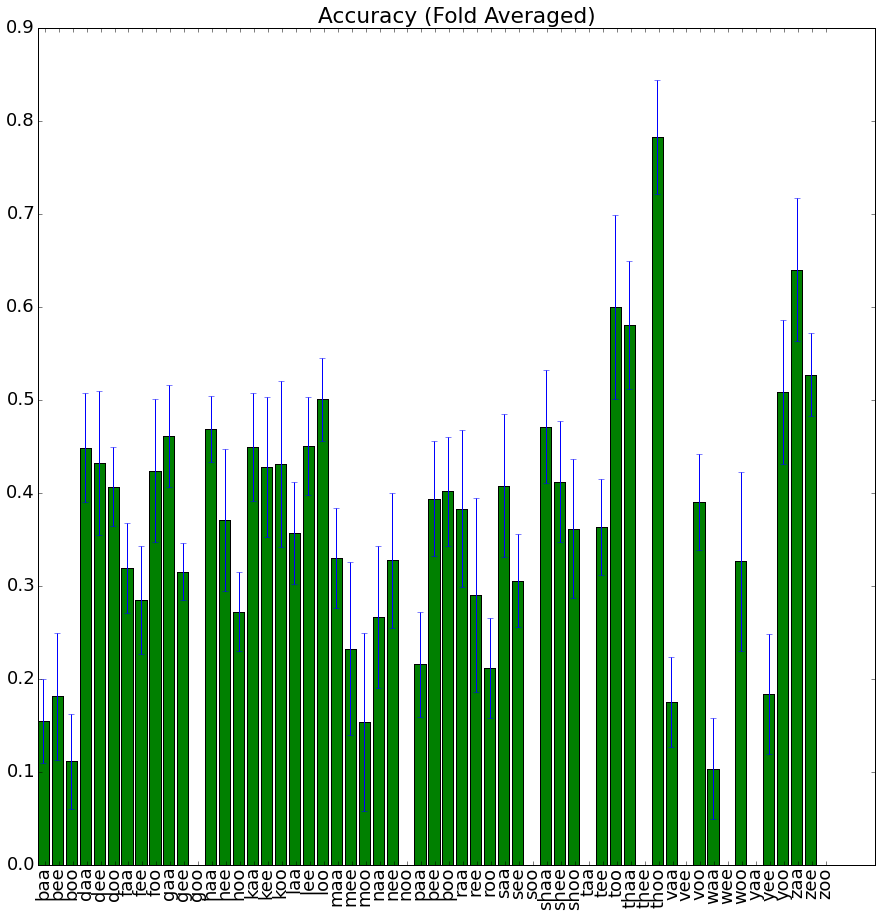

In [24]:
plt.bar(range(cv_dim), accuracy_per_cv.mean(0), color='g', yerr=accuracy_per_cv.std(0)/np.sqrt(10))
plt.title('Accuracy (Fold Averaged)')
plt.xticks(np.arange(cv_dim)+.5,ecog_E_lbls, rotation=90)
plt.show()

In [25]:
consonant_order = ['gee', 'kee', 'yaa', 'gaa', 'yee', 'goo', 'koo', 'kaa', 'haa', 'hee', 'hoo', 'noo',
                   'yoo', 'raa', 'roo', 'baa', 'paa', 'pee', 'boo', 'moo', 'waa', 'maa', 'poo', 'woo',
                   'bee', 'mee', 'wee', 'ree', 'faa', 'vaa', 'fee', 'foo', 'vee', 'voo', 'daa', 'taa',
                   'tee', 'dee', 'doo', 'too', 'laa', 'lee', 'loo', 'naa', 'nee', 'thaa', 'thoo',
                   'thee', 'saa', 'see', 'zaa', 'zee', 'soo', 'shaa', 'shee', 'shoo', 'zoo']

vowel_order = ['hee', 'shee', 'nee', 'kee', 'yee', 'fee', 'vee', 'wee', 'ree', 'bee', 'gee', 'pee', 'mee',
               'dee', 'see', 'lee', 'zee', 'tee', 'saa', 'thaa', 'zaa', 'thee', 'baa', 'faa', 'gaa',
               'paa', 'naa', 'maa', 'waa', 'daa', 'raa', 'taa', 'kaa', 'laa', 'yaa', 'vaa', 'haa',
               'shaa', 'boo', 'shoo', 'moo', 'roo', 'doo', 'foo', 'zoo', 'thoo', 'hoo', 'too', 'soo', 'goo', 'koo',
               'woo', 'loo', 'poo', 'noo', 'yoo', 'voo']

consonants = ['b', 'd', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'p', 'r', 's', 'sh', 't', 'th',
              'v', 'w', 'y', 'z']
vowels = ['aa', 'ee', 'oo']

assert set(ecog_E_lbls) == set(consonant_order)
assert set(ecog_E_lbls) == set(vowel_order)

to_consonant = [list(ecog_E_lbls).index(cv) for cv in consonant_order]
to_vowel = [list(ecog_E_lbls).index(cv) for cv in vowel_order]

In [27]:
conf_matrix = cv_mat.sum(0)
conf_matrix_consonant = np.zeros_like(conf_matrix)
conf_matrix_vowel = np.zeros_like(conf_matrix)
    
conf_matrix_consonant[:] = conf_matrix[to_consonant][:,to_consonant]
conf_matrix_vowel[:] = conf_matrix[to_vowel][:,to_vowel]

<matplotlib.colorbar.Colorbar instance at 0x7f4e7f6cf908>

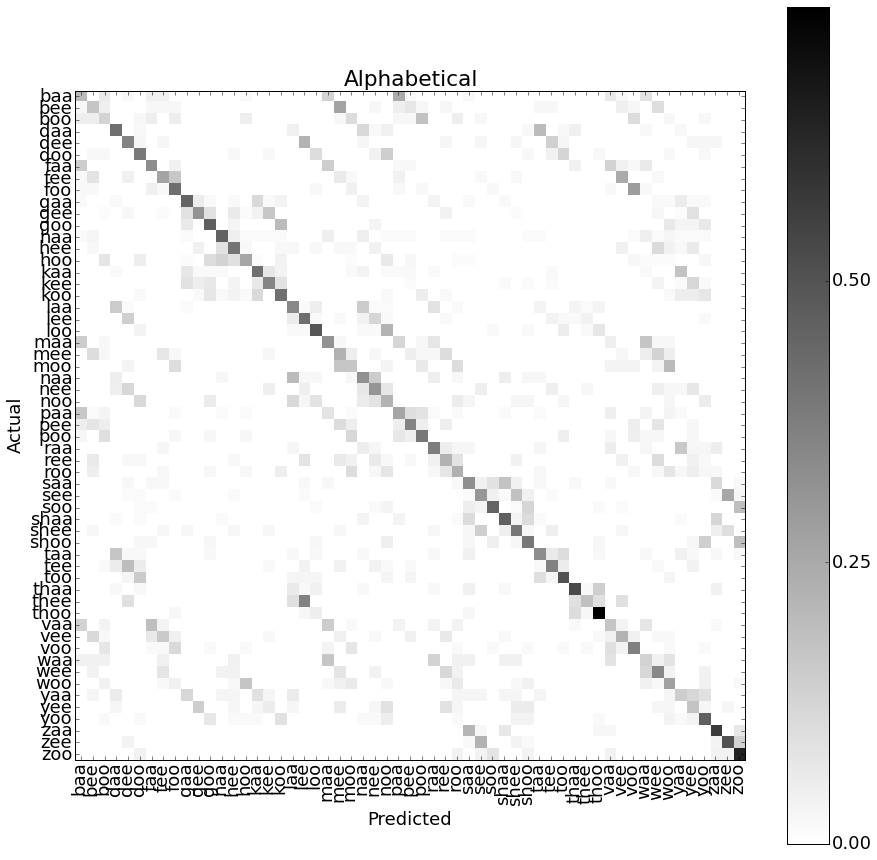

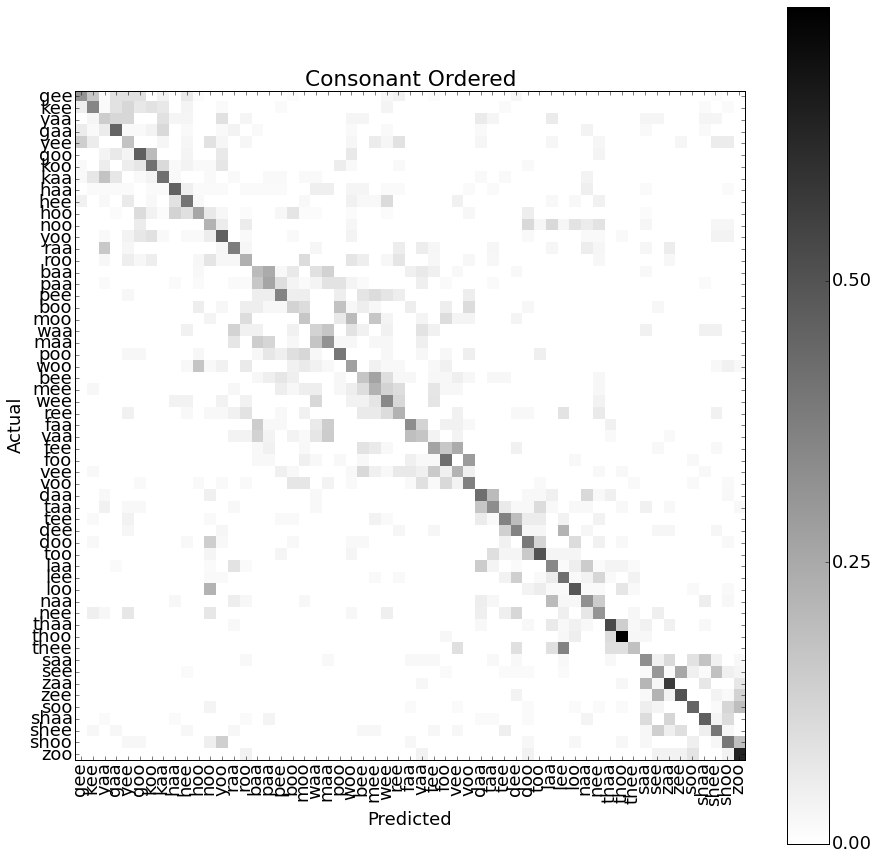

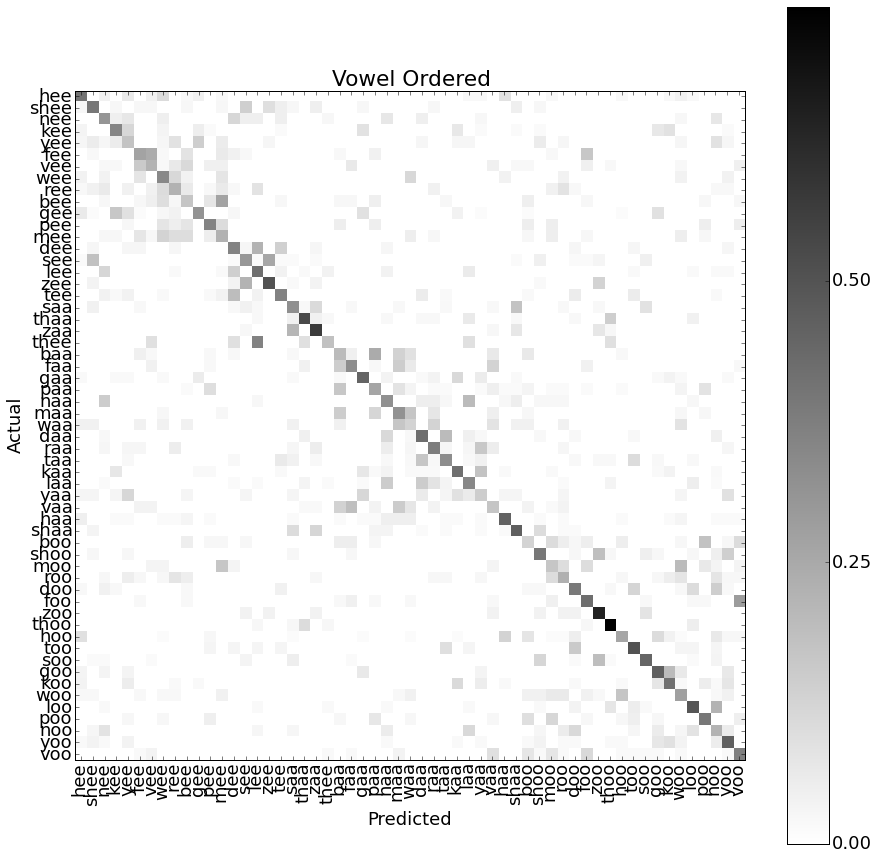

In [29]:
ticks = [0,.25,.5,.75,1]

plt.imshow(conf_matrix/conf_matrix.sum(1, keepdims=True),interpolation='nearest', cmap='gray_r')
plt.title('Alphabetical')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(np.arange(cv_dim),ecog_E_lbls, rotation=90)
plt.yticks(np.arange(cv_dim),ecog_E_lbls)
plt.colorbar(ticks=ticks)
plt.figure()
plt.imshow(conf_matrix_consonant/conf_matrix_consonant.sum(1, keepdims=True),interpolation='nearest', cmap='gray_r')
plt.title('Consonant Ordered')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(np.arange(cv_dim),ecog_E_lbls[to_consonant], rotation=90)
plt.yticks(np.arange(cv_dim),ecog_E_lbls[to_consonant])
plt.colorbar(ticks=ticks)
plt.figure()
plt.imshow(conf_matrix_vowel/conf_matrix_vowel.sum(1, keepdims=True),interpolation='nearest', cmap='gray_r')
plt.title('Vowel Ordered')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(np.arange(cv_dim),ecog_E_lbls[to_vowel], rotation=90)
plt.yticks(np.arange(cv_dim),ecog_E_lbls[to_vowel])
plt.colorbar(ticks=ticks)

In [29]:
np.diag(conf_matrix/conf_matrix.sum(1, keepdims=True)).max()

0.11363636363636363

In [42]:
hat_mat.max()

0.36181458853353887

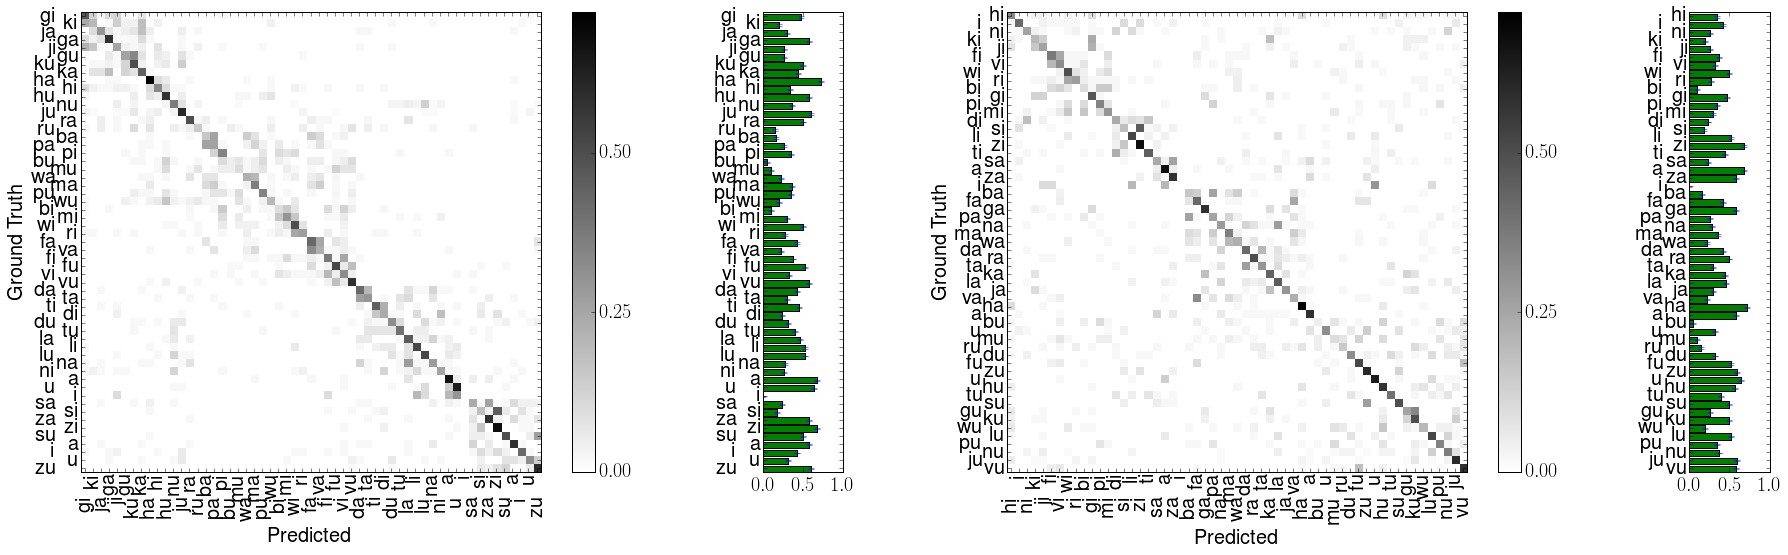

In [20]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals

phoneme_map = {'aa': 'a',
               'ee': 'i',
               'oo': 'u',
               'y': 'j',
               'th': ' ',#u'\u03B8',#u'θ'.encode("utf8"),
               'sh': ' '}#u'\u0283'}#u'ʃ'.encode("utf8")}

def to_phonetic(syllables):
    rval = []
    for syl in syllables:
        for k, v in phoneme_map.iteritems():
            syl = syl.replace(k, v)
        rval.append(syl)
    return rval

tick_offset = .02
tick_scale = .05
ratio = 6

rcParams['font.size'] = 20
rcParams['font.family'] = 'sans-serif'
rcParams['text.usetex']=True
rcParams['text.latex.unicode']=True
ticks = [0,.25,.5,.75,1]
f = plt.figure(figsize=(26, 8))
gs = matplotlib.gridspec.GridSpec(1, 4, width_ratios=[6,1,6,1])
#f.set_size_inches(40, 8)
cl = [0,1]
ax0 = plt.subplot(gs[0])
img = ax0.imshow(np.clip(conf_matrix_consonant/conf_matrix_consonant.sum(1, keepdims=True),
                         cl[0], cl[1]),
                 interpolation='nearest', cmap='gray_r')
ax0.set_ylabel('Ground Truth')
ax0.set_xlabel('Predicted')
ax0.set_xticks(np.arange(y_dim))
ax0.set_xticklabels(to_phonetic(ecog_E_lbls[to_consonant]), rotation=90)
ax0.set_yticks(np.arange(y_dim))
ax0.set_yticklabels(to_phonetic(ecog_E_lbls[to_consonant]))
pos = 0
for label in ax0.yaxis.get_majorticklabels():
    label.set_position([tick_scale*((pos%2)-.5)-tick_offset, 0])
    pos += 1
pos = 0
for label in ax0.xaxis.get_majorticklabels():
    label.set_position([0, tick_scale*((pos%2)-.5)-tick_offset])
    pos += 1
cbar = f.colorbar(img, ax = ax0, ticks=ticks)

ax1 = plt.subplot(gs[1])
ax1.barh(range(y_dim), accuracy_mat.mean(0)[to_consonant][::-1], color='g',
         yerr=accuracy_mat.std(0, ddof=1)/np.sqrt(10))
ax1.set_yticks(np.arange(y_dim)+.5)
ax1.set_yticklabels(to_phonetic(ecog_E_lbls[to_consonant][::-1]))
ax1.set_ylim([0,57])
ax1.set_xticks([0, .5, 1])
ax1.set_aspect(.1)
ax1.set_anchor('W')
pos = 0
for label in ax1.yaxis.get_majorticklabels():
    label.set_position([ratio*(tick_scale*((pos%2)-.5)-tick_offset), 0])
    pos += 1

ax2 = plt.subplot(gs[2])
img = ax2.imshow(np.clip(conf_matrix_vowel/conf_matrix_vowel.sum(1, keepdims=True),
                         cl[0], cl[1]),
                 interpolation='nearest', cmap='gray_r')
ax2.set_ylabel('Ground Truth')
ax2.set_xlabel('Predicted')
ax2.set_xticks(np.arange(y_dim))
ax2.set_xticklabels(to_phonetic(ecog_E_lbls[to_vowel]), rotation=90)
ax2.set_yticks(np.arange(y_dim))
ax2.set_yticklabels(to_phonetic(ecog_E_lbls[to_vowel]))
for label in ax2.yaxis.get_majorticklabels():
    label.set_position([tick_scale*((pos%2)-.5)-tick_offset, 0])
    pos += 1
pos = 0
for label in ax2.xaxis.get_majorticklabels():
    label.set_position([0, tick_scale*((pos%2)-.5)-tick_offset])
    pos += 1
cbar = f.colorbar(img, ax = ax2, ticks=ticks)

ax3 = plt.subplot(gs[3])
ax3.barh(range(y_dim), accuracy_mat.mean(0)[to_vowel][::-1], color='g',
         yerr=accuracy_mat.std(0, ddof=1)/np.sqrt(10))
ax3.set_yticks(np.arange(y_dim)+.5)
ax3.set_yticklabels(to_phonetic(ecog_E_lbls[to_vowel][::-1]))
ax3.set_ylim([0,57])
ax3.set_xticks([0, .5, 1])
ax3.set_aspect(.1)
ax3.set_anchor('W')
for label in ax3.yaxis.get_majorticklabels():
    label.set_position([ratio*(tick_scale*((pos%2)-.5)-tick_offset), 0])
    pos += 1
f.tight_layout()

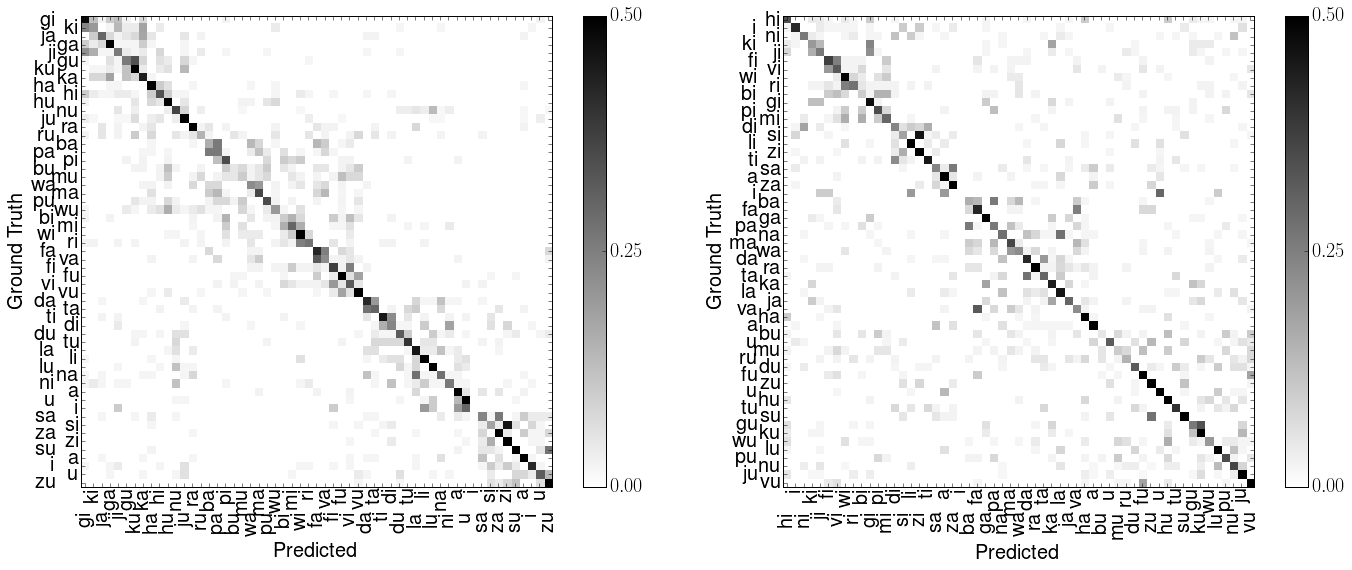

In [25]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals

phoneme_map = {'aa': 'a',
               'ee': 'i',
               'oo': 'u',
               'y': 'j',
               'th': ' ',#u'\u03B8',#u'θ'.encode("utf8"),
               'sh': ' '}#u'\u0283'}#u'ʃ'.encode("utf8")}

def to_phonetic(syllables):
    rval = []
    for syl in syllables:
        for k, v in phoneme_map.iteritems():
            syl = syl.replace(k, v)
        rval.append(syl)
    return rval

tick_offset = .02
tick_scale = .05
ratio = 6

rcParams['font.size'] = 20
rcParams['font.family'] = 'sans-serif'
rcParams['text.usetex']=True
rcParams['text.latex.unicode']=True
ticks = [0,.25,.5,.75,1]
f = plt.figure(figsize=(20, 8))
gs = matplotlib.gridspec.GridSpec(1, 2)#, width_ratios=[6,1,6,1])
#f.set_size_inches(40, 8)
cl = [0,.5]
ax0 = plt.subplot(gs[0])
img = ax0.imshow(np.clip(conf_matrix_consonant/conf_matrix_consonant.sum(1, keepdims=True),
                         cl[0], cl[1]),
                 interpolation='nearest', cmap='gray_r')
ax0.set_ylabel('Ground Truth')
ax0.set_xlabel('Predicted')
ax0.set_xticks(np.arange(y_dim))
ax0.set_xticklabels(to_phonetic(ecog_E_lbls[to_consonant]), rotation=90)
ax0.set_yticks(np.arange(y_dim))
ax0.set_yticklabels(to_phonetic(ecog_E_lbls[to_consonant]))
pos = 0
for label in ax0.yaxis.get_majorticklabels():
    label.set_position([tick_scale*((pos%2)-.5)-tick_offset, 0])
    pos += 1
pos = 0
for label in ax0.xaxis.get_majorticklabels():
    label.set_position([0, tick_scale*((pos%2)-.5)-tick_offset])
    pos += 1

cbar = f.colorbar(img, ax = ax0, ticks=ticks)
"""
ax1 = plt.subplot(gs[1])
ax1.barh(range(y_dim), accuracy_mat.mean(0)[to_consonant][::-1], color='g',
         yerr=accuracy_mat.std(0, ddof=1)/np.sqrt(10))
ax1.set_yticks(np.arange(y_dim)+.5)
ax1.set_yticklabels(to_phonetic(ecog_E_lbls[to_consonant][::-1]))
ax1.set_ylim([0,57])
ax1.set_xticks([0, .5, 1])
ax1.set_aspect(.1)
ax1.set_anchor('W')
pos = 0
for label in ax1.yaxis.get_majorticklabels():
    label.set_position([ratio*(tick_scale*((pos%2)-.5)-tick_offset), 0])
    pos += 1
"""

ax1 = plt.subplot(gs[1])
img = ax1.imshow(np.clip(conf_matrix_vowel/conf_matrix_vowel.sum(1, keepdims=True),
                         cl[0], cl[1]),
                 interpolation='nearest', cmap='gray_r')
ax1.set_ylabel('Ground Truth')
ax1.set_xlabel('Predicted')
ax1.set_xticks(np.arange(y_dim))
ax1.set_xticklabels(to_phonetic(ecog_E_lbls[to_vowel]), rotation=90)
ax1.set_yticks(np.arange(y_dim))
ax1.set_yticklabels(to_phonetic(ecog_E_lbls[to_vowel]))
for label in ax1.yaxis.get_majorticklabels():
    label.set_position([tick_scale*((pos%2)-.5)-tick_offset, 0])
    pos += 1
pos = 0
for label in ax1.xaxis.get_majorticklabels():
    label.set_position([0, tick_scale*((pos%2)-.5)-tick_offset])
    pos += 1

cbar = f.colorbar(img, ax = ax1, ticks=ticks)
"""
ax3 = plt.subplot(gs[3])
ax3.barh(range(y_dim), accuracy_mat.mean(0)[to_vowel][::-1], color='g',
         yerr=accuracy_mat.std(0, ddof=1)/np.sqrt(10))
ax3.set_yticks(np.arange(y_dim)+.5)
ax3.set_yticklabels(to_phonetic(ecog_E_lbls[to_vowel][::-1]))
ax3.set_ylim([0,57])
ax3.set_xticks([0, .5, 1])
ax3.set_aspect(.1)
ax3.set_anchor('W')
for label in ax3.yaxis.get_majorticklabels():
    label.set_position([ratio*(tick_scale*((pos%2)-.5)-tick_offset), 0])
    pos += 1
"""
f.tight_layout()

### CV Classification

In [ ]:
c_matrices = {}
v_matrices = {}
c_accuracy_per_label = {}
v_accuracy_per_label = {}
c_accuracy_mat = np.zeros((len(files), y_dim))
v_accuracy_mat = np.zeros((len(files), y_dim))
c_total_mat = np.zeros((len(files), y_dim))
v_total_mat = np.zeros((len(files), y_dim))
for ii in xrange(10):
    conf_matrix = np.zeros((y_dim, y_dim))
    accuracy = np.zeros(y_dim)
    total = np.zeros(y_dim)
    total2 = np.zeros_like(total)
    for idx, idy in indices_dict[file_name]:
        conf_matrix[idx,idy] += 1
        if idx == idy:
            accuracy[idx] += 1
        total[idx] += 1
    total2 = total.copy()
    total2[total == 0] = 1
    accuracy_mat[ii] = accuracy/total2
    total_mat[ii] = total2
    accuracy_per_label[file_name] = accuracy/total
    matrices[file_name] = conf_matrix
    plt.bar(range(y_dim), accuracy/total)
    plt.title('Accuracy Fold '+str(ii))
    plt.xticks(np.arange(y_dim)+.5,ecog_E_lbls, rotation=90)
    plt.figure()
    plt.bar(range(y_dim), total)
    plt.title('Total Fold '+str(ii))
    plt.xticks(np.arange(y_dim)+.5,ecog_E_lbls, rotation=90)
    plt.figure()
    plt.imshow(conf_matrix,interpolation='nearest', cmap='gray_r')
    plt.title('Fold '+str(ii))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks(range(y_dim),ecog_E_lbls, rotation=90)
    plt.yticks(range(y_dim),ecog_E_lbls)
    plt.figure()

## Spectral Clustering

In [9]:
from sklearn.cluster import SpectralClustering as sc

In [25]:
sc_obj = sc(n_clusters=4, affinity='precomputed', assign_labels='discretize')
sc_obj.fit(conf_matrix)

SpectralClustering(affinity='precomputed', assign_labels='discretize',
          coef0=1, degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=4, n_init=10, n_neighbors=10,
          random_state=None)

In [26]:
clusters = sc_obj.labels_
idxs = np.argsort(clusters)
sorted_labels = ecog_E_lbls[idxs]
clustered_idxs = []
clustered_labels = []
for label in sorted(set(clusters)):
    clustered_idxs.append(idxs[clusters == label])
    clustered_labels.append(np.array(sorted(ecog_E_lbls[clustered_idxs[-1]])))

In [27]:
sorted_labels

array(['koo', 'kee', 'kaa', 'hoo', 'hee', 'haa', 'goo', 'gee', 'gaa',
       'yaa', 'yee', 'yoo', 'nee', 'thee', 'raa', 'thaa', 'too', 'noo',
       'thoo', 'naa', 'taa', 'lee', 'laa', 'tee', 'doo', 'dee', 'daa',
       'loo', 'waa', 'voo', 'vee', 'vaa', 'wee', 'woo', 'baa', 'pee',
       'moo', 'bee', 'boo', 'faa', 'roo', 'ree', 'poo', 'fee', 'paa',
       'foo', 'mee', 'maa', 'zaa', 'shaa', 'zee', 'saa', 'see', 'shoo',
       'shee', 'soo', 'zoo'], dtype=object)

In [35]:
np.array(consonant_order)

array(['gee', 'kee', 'yaa', 'gaa', 'yee', 'goo', 'koo', 'kaa', 'haa',
       'hee', 'hoo', 'noo', 'yoo', 'raa', 'roo', 'baa', 'paa', 'pee',
       'boo', 'moo', 'waa', 'maa', 'poo', 'woo', 'bee', 'mee', 'wee',
       'ree', 'faa', 'vaa', 'fee', 'foo', 'vee', 'voo', 'daa', 'taa',
       'tee', 'dee', 'doo', 'too', 'laa', 'lee', 'loo', 'naa', 'nee',
       'thaa', 'thoo', 'thee', 'saa', 'see', 'zaa', 'zee', 'soo', 'shaa',
       'shee', 'shoo', 'zoo'], 
      dtype='|S4')

In [37]:
set(clusters)

{0, 1, 2, 3}

In [28]:
clustered_labels

[array(['nee', 'noo', 'raa', 'saa', 'see', 'shoo', 'thaa', 'thee', 'too',
        'yaa', 'yee', 'yoo'], 
       dtype='|S4'),
 array(['daa', 'dee', 'doo', 'faa', 'fee', 'haa', 'hee', 'hoo', 'naa',
        'paa', 'poo', 'ree', 'roo', 'taa', 'thoo', 'vee'], 
       dtype='|S4'),
 array(['foo', 'gaa', 'gee', 'goo', 'kaa', 'kee', 'koo', 'laa', 'lee',
        'loo', 'maa', 'mee', 'shaa', 'tee', 'vaa', 'voo', 'waa', 'wee',
        'zaa', 'zee'], 
       dtype='|S4'),
 array(['baa', 'bee', 'boo', 'moo', 'pee', 'shee', 'soo', 'woo', 'zoo'], 
       dtype='|S4')]

# ITR

In [67]:
def naive(n, p):
    rval = np.log2(n)
    if p > 0.:
        rval += p*np.log2(p)
    if (1-p) > 0.:
        rval += (1.-p)*np.log2((1.-p)/(n-1.))
    return rval

def information(conf):
    inf = 0.
    N = conf.shape[0]
    for ii in xrange(N):
        Pi = conf[ii].sum()/conf.sum()
        if Pi > 0:
            for jj in xrange(N):
                if conf[ii,jj] > 0:
                    Pij = conf[ii,jj]/conf.sum()
                    Pigj = conf[ii,jj]/conf[:,jj].sum()
                    delta = Pij*np.log2(Pigj/Pi)
                    inf += delta
    return inf

def information2(conf):
    inf = 0.
    N = conf.shape[0]
    for ii in xrange(N):
        Py = conf[ii].sum()/conf.sum()
        if Py > 0:
            for jj in xrange(N):
                if conf[ii,jj] > 0:
                    Py_hat = conf[:,jj].sum()/conf.sum()
                    Py_hatgy = conf[ii,jj]/conf[ii].sum()
                    delta = Py_hatgy*Py*np.log2(Py_hatgy/Py_hat)
                    inf += delta
    return inf

def naive_information(conf):
    n = conf.shape[0]
    p = np.diag(conf).sum()/conf.sum()
    return naive(n, p)

def mult(n, p):
    return np.log2(n)*p

def mult_information(conf):
    n = conf.shape[0]
    p = np.diag(conf).sum()/conf.sum()
    return mult(n, p)

In [76]:
print information(conf_matrix)
print information2(conf_matrix)
print naive_information(conf_matrix)
print mult_information(conf_matrix)

1.3876640891
1.3876640891
1.37588456641
1.54140627933


In [46]:
p = np.diag(conf_matrix).sum()/conf_matrix.sum()
n = conf_matrix.shape[0]
test_matrix = np.ones((n, n))*(1.-p)/(n-1.)
test_matrix = test_matrix - np.diag(np.diag(test_matrix)) + np.diag(np.ones(n)*p)
print information(test_matrix)
print information2(test_matrix)
print naive_information(test_matrix)
print mult_information(test_matrix)
print np.log2(57)

1.31222679617
1.31222679617
1.31222679617
2.25968830701
5.83289001416


In [23]:
n = 15
p = .192
print naive(n, p)

0.124911212126


In [5]:
naive(57, .207)

0.49194848168659

In [26]:
naive(57, .587)

2.4564035077446955

In [38]:
np.log2(17*17)*.188/.52

2.9555500544425528

In [41]:
naive(24*24, .148)/.52

1.4509079828405445

In [44]:
-np.log2(24*24)*.188/.52

-3.3152805774445282

In [77]:
def channel_cap_bfgs(conf, eps):
    n = conf.shape[0]
    conf = np.maximum(conf, eps)
    Pigj = conf.T/conf.T.sum(axis=0, keepdims=True)
    def f(Pj):
        Pi = Pigj.dot(Pj)
        Pi_r = Pi[:, np.newaxis]
        Pj_r = Pj[np.newaxis, :]
        locs = Pi_r*Pj_r*Pigj > 0
        Iij = np.zeros_like(Pigj)
        Iij[locs] = ((Pigj*Pj_r)*np.log2(Pigj/Pi_r))[locs]
        return -Iij.sum()
    def c(Pj):
        return Pj.sum()-1.
    return f, c

In [ ]:
I, Pj = channel_cap(conf_matrix)
print I
print Pj.argmax()
plt.plot(Pj)
plt.show()

initial 1.38787556057
result 1.38788323977
approx 1.37588456641
0.0
0.332245473024 0.33489263112


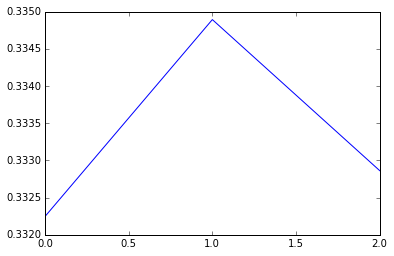

In [78]:
from scipy.optimize import minimize
f, c = channel_cap_bfgs(conf_matrix, 1.e-12)
x0 = np.ones(y_dim)/y_dim
print 'initial', -f(x0)
res = minimize(f, x0, bounds=y_dim*[[0., 1.]], constraints={'type':'eq' ,'fun': c}, options={'disp': False})
print 'result',-f(res.x)
print 'approx',naive_information(conf_matrix)
print c(res.x)
print res.x.min(), res.x.max()
plt.plot(res.x)
plt.show()

# Performance with Samples

In [88]:
frac = np.array([.5, .6, .7, .8, .9, 1.])
total = 2095

data = [fc_point, fc_lin_point, conv_point]
colors = [('red', 'red'), ('black', 'black'), ('gray', 'gray')]
descriptions = ['Fully-connected', 'Linear', 'Convolutional']
linestyle = ['-', ':', '--']

Fully-connected
(6, 10)
(6,)
Linear
(6, 10)
(6,)
Convolutional
(6, 10)
(6,)


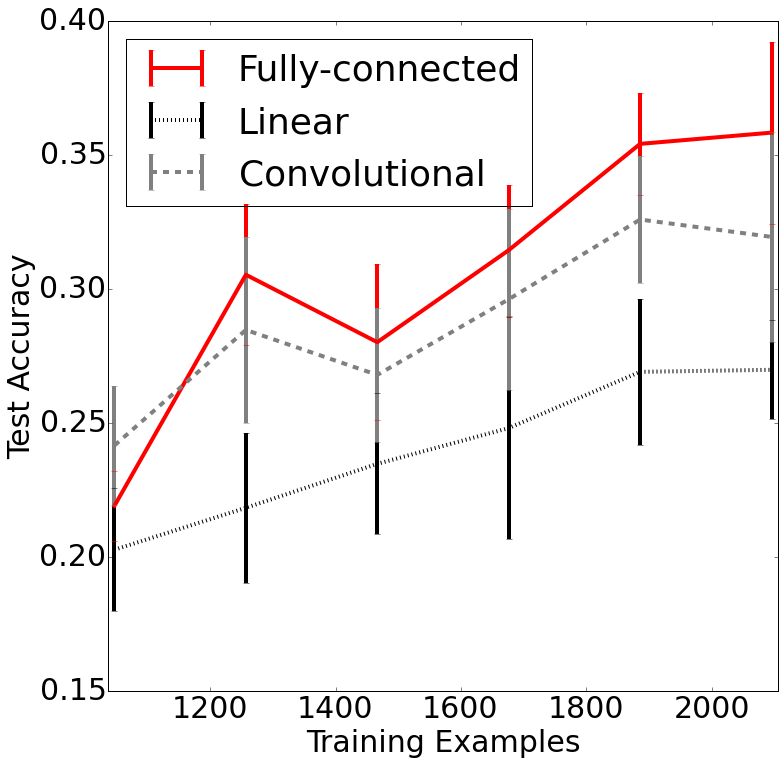

In [90]:
from pylab import rcParams
rcParams['legend.loc'] = 'upper left'
rcParams['figure.figsize'] = 12, 12
rcParams['font.size'] = 30
for y, c, d, ls in zip(data, colors, descriptions, linestyle):
    e, f = c
    y = np.array(y)
    print d
    print y.shape
    print frac.shape
    plt.errorbar(total*frac, 1.-y.mean(1), yerr=y.std(1), color=e, label=d, lw=4, ls=ls)
plt.xlim([frac[0]*total-10, total+10])
plt.xlabel('Training Examples')
plt.ylabel('Test Accuracy')
plt.legend()
plt.savefig('/home/jesse/scale.pdf')

## Regression

In [256]:
from scipy.stats import linregress
n = 10000
rng = np.random.RandomState(20150519)
fc_slope = np.zeros(n)
lin_slope = np.zeros(n)

fc_mean = np.array(fc)
fc_cov = np.diag(fc_std)
lin_mean = np.array(fc_lin)
lin_cov = np.diag(fc_lin_std)

x = total*frac/1000.

for ii in xrange(n):
    y_fc = rng.multivariate_normal(fc_mean, fc_cov)
    y_lin = rng.multivariate_normal(lin_mean, lin_cov)
    fc_slope[ii] = linregress(x, y_fc)[0]
    lin_slope[ii] = linregress(x, y_lin)[0]
    
print fc_slope.mean(), fc_slope.std()
print lin_slope.mean(), lin_slope.std()

0.127228315912 0.173464540702
0.0731355760419 0.169285036336


## Regression 2

In [86]:
fc_point=[[0.797709882259, 0.80534350872, 0.767175555229, 0.778625965118, 0.778625965118, 0.770992338657,
           0.786259531975, 0.759541988373, 0.786259531975, 0.778625905514],
          [0.687022864819, 0.698473274708, 0.667938888073, 0.751908421516, 0.68320608139, 0.660305321217,
           0.687022984028, 0.702290117741, 0.679389297962, 0.729007601738],
          [0.698473274708, 0.75572514534, 0.702290058136, 0.767175555229, 0.690839648247, 0.671755671501,
           0.713740468025, 0.721374034882, 0.72519081831, 0.751908361912],
          [0.675572514534, 0.72519081831, 0.656488537788, 0.679389297962, 0.679389357567, 0.69465649128,
           0.687022924423, 0.664122104645, 0.660305321217, 0.732824385166],
          [0.633587837219, 0.656488537788, 0.614503800869, 0.664122164249, 0.622137367725, 0.660305380821,
           0.629770994186, 0.656488597393, 0.645038187504, 0.675572514534],
          [0.625954210758, 0.709923624992, 0.614503800869, 0.687022924423, 0.648854970932, 0.618320643902,
           0.614503800869, 0.641221344471, 0.595419824123, 0.660305321217]]
fc_lin_point=[[0.828244268894, 0.80534350872, 0.77480918169, 0.835877835751, 0.786259531975, 0.774809122086,
               0.793893158436, 0.820610702038, 0.786259531975, 0.767175495625],
              [0.80534350872, 0.81679391861, 0.744274795055, 0.816793859005, 0.763358712196, 0.755725204945,
               0.759541988373, 0.820610702038, 0.763358771801, 0.770992338657],
              [0.767175555229, 0.790076315403, 0.717557251453, 0.778625905514, 0.75572514534, 0.763358771801,
               0.729007661343, 0.786259591579, 0.755725204945, 0.809160292149],
              [0.763358771801, 0.77480918169, 0.652671694756, 0.767175614834, 0.751908361912, 0.751908421516,
               0.702290117741, 0.790076315403, 0.763358771801, 0.801526725292],
              [0.698473274708, 0.770992338657, 0.68320608139, 0.767175555229, 0.759541988373, 0.72519081831,
               0.717557251453, 0.721374094486, 0.736641168594, 0.729007661343],
              [0.72519081831, 0.759541988373, 0.713740468025, 0.763358771801, 0.732824385166, 0.717557251453,
               0.702290058136, 0.721374034882, 0.72519081831, 0.740458011627]]
conv_point=[[0.782442748547, 0.782442688942, 0.75572514534, 0.778625905514, 0.790076375008, 0.748091638088,
             0.736641168594, 0.748091638088, 0.740458011627, 0.721374034882],
            [0.732824385166, 0.748091578484, 0.732824444771, 0.740458011627, 0.729007601738, 0.69465649128,
             0.656488537788, 0.751908361912, 0.648854970932, 0.717557191849],
            [0.732824444771, 0.790076375008, 0.702290058136, 0.721374034882, 0.709923684597, 0.748091638088,
             0.732824385166, 0.725190877914, 0.706106901169, 0.751908421516],
            [0.72519081831, 0.767175555229, 0.679389297962, 0.667938888073, 0.706106841564, 0.690839707851,
             0.660305321217, 0.736641228199, 0.671755731106, 0.732824444771],
            [0.690839707851, 0.713740468025, 0.656488537788, 0.706106841564, 0.679389297962, 0.660305321217,
             0.629770994186, 0.656488537788, 0.671755731106, 0.675572514534],
            [0.729007720947, 0.72519081831, 0.679389297962, 0.72519081831, 0.690839648247, 0.660305321217,
             0.606870174408, 0.675572514534, 0.625954210758, 0.687022924423]]

In [6]:
from scipy.stats import linregress
x = total*frac/1000.
fc_point = np.array(fc_point)
slope_fc, intercept, r_value, p_value, std_err_fc = linregress(np.tile(x[:,np.newaxis], (1, 10)).ravel(),
                                                         1.-fc_point.ravel())
print slope_fc, intercept, std_err_fc

fc_lin_point = np.array(fc_lin_point)
slope_lin, intercept, r_value, p_value, std_err_lin = linregress(np.tile(x[:,np.newaxis], (1, 10)).ravel(),
                                                         1.-fc_lin_point.ravel())
print slope_lin, intercept, std_err_lin
print 'z fc' , (slope_fc-slope_lin)/np.sqrt(std_err_fc**2+std_err_lin**2)
print 'p < .01'

conv_point = np.array(conv_point)
slope_conv, intercept, r_value, p_value, std_err_conv = linregress(np.tile(x[:,np.newaxis], (1, 10)).ravel(),
                                                         1.-conv_point.ravel())
print slope_conv, intercept, std_err_conv
print 'z conv' , (slope_conv-slope_lin)/np.sqrt(std_err_conv**2+std_err_lin**2)

0.119670074709 0.117248300711 0.0117867714862
0.0683977780309 0.132988013824 0.0104999943288
z fc 3.24808991544
p < .01
0.0738112974444 0.173336982443 0.0120239934125
z conv 0.339123257775


In [9]:
fc_point.shape

(6, 10)

In [17]:
1.-np.tile(x[:,np.newaxis], (1, 10)).ravel()[0]

array([ 1.0475,  1.0475,  1.0475,  1.0475,  1.0475,  1.0475,  1.0475,
        1.0475,  1.0475,  1.0475])

In [16]:
x.shape

(6,)

In [36]:
indices_dict.keys()

['299724_fold4.pkl',
 '299724_fold7.pkl',
 '299724_fold6.pkl',
 '299724_fold8.pkl',
 '299724_fold9.pkl',
 '299724_fold0.pkl',
 '299724_fold5.pkl',
 '299724_fold3.pkl',
 '299724_fold1.pkl',
 '299724_fold2.pkl']

In [17]:
num = 0
for key in sorted(y_hat_dict.keys()):
    num += y_hat_dict[key].shape[0]
features = np.zeros((num, 57))
classes = np.zeros((num, 2))
idx = 0
for ii, key in enumerate(sorted(y_hat_dict.keys())):
    n = y_hat_dict[key].shape[0]
    features[idx:idx+n] = y_hat_dict[key]
    classes[idx:idx+n] = indices_dict[key]
    idx += n

In [28]:
np.all(features.argmax(1) == classes[:,1])

True

In [38]:
ecog_E_lbls

array(['baa', 'bee', 'boo', 'daa', 'dee', 'doo', 'faa', 'fee', 'foo',
       'gaa', 'gee', 'goo', 'haa', 'hee', 'hoo', 'kaa', 'kee', 'koo',
       'laa', 'lee', 'loo', 'maa', 'mee', 'moo', 'naa', 'nee', 'noo',
       'paa', 'pee', 'poo', 'raa', 'ree', 'roo', 'saa', 'see', 'soo',
       'shaa', 'shee', 'shoo', 'taa', 'tee', 'too', 'thaa', 'thee', 'thoo',
       'vaa', 'vee', 'voo', 'waa', 'wee', 'woo', 'yaa', 'yee', 'yoo',
       'zaa', 'zee', 'zoo'], dtype=object)

In [18]:
with h5py.File('/home/jesse/clustering_data_linear.h5', 'w') as f:
    f.create_dataset('X', data=features)
    f.create_dataset('y', data=classes)
    f.create_dataset('labels', data=list(ecog_E_lbls))
    f.create_dataset('conf', data=conf_matrix/conf_matrix.sum(1, keepdims=True))
    f.create_dataset('soft_conf', data=hat_mat/hat_mat.sum(1, keepdims=True))
    f.create_dataset('accuracy', data=accuracy_mat)

In [13]:
with h5py.File('/home/jesse/accuracy.h5', 'w') as f:
    f.create_dataset('accuracy', data=accuracy_mat)

In [37]:
with h5py.File('/home/jesse/clustering_data.h5', 'r') as f:
    X = f['X'].value
    y = f['y'].value
    labels = f['labels'].value
    conf = f['conf'].value
    soft = f['soft_conf'].value

In [38]:
assert np.all(X == features)
assert np.all(y == classes)
assert np.all([l == e for l, e in zip(labels, ecog_E_lbls)])
assert np.all(conf == conf_matrix/conf_matrix.sum(1, keepdims=True))
assert np.all(soft == hat_mat/hat_mat.sum(1, keepdims=True))

# Timing Comparison

In [9]:
pairs = [('baa', 'paa'), ('bee', 'pee'), ('boo', 'poo'),
         ('daa', 'taa'), ('dee', 'tee'), ('doo', 'too'),
         ('gaa', 'kaa'), ('gee', 'kee'), ('goo', 'koo'),
         ('zaa', 'saa'), ('zee', 'see'), ('zoo', 'soo'),
         ('vaa', 'faa'), ('vee', 'fee'), ('voo', 'foo')]
lbls = list(ecog_E_lbls)
confs = np.zeros((len(pairs), 10, 2, 2))
errors = np.zeros(10)
for ii, f in enumerate(files):
    m = matrices[f]
    errors[ii] = m.sum()-np.diag(m).sum()
    for jj, pair in enumerate(pairs):
        one, two = pair
        idx = lbls.index(one)
        idy = lbls.index(two)
        confs[jj, ii, 0, 0] = m[idx, idx]
        confs[jj, ii, 1, 1] = m[idy, idy]
        confs[jj, ii, 1, 0] = m[idy, idx]
        confs[jj, ii, 0, 1] = m[idx, idy]

In [10]:
pcts = np.zeros(10)
for ii in xrange(10):
    m = confs[:, ii].sum(axis=0)
    pcts[ii] = (m.sum()-np.diag(m).sum())/errors[ii]

In [33]:
print 'fc pct aug'
print pcts.mean(), pcts.std()

fc pct
0.165260305169 0.0178426662554


In [11]:
print 'conv pct'
print pcts.mean(), pcts.std()

conv pct
0.139511450307 0.0223233887892


In [11]:
print 'fc pct'
print pcts.mean(), pcts.std()

fc pct
0.161661828177 0.0195010384903


# ITR Plot

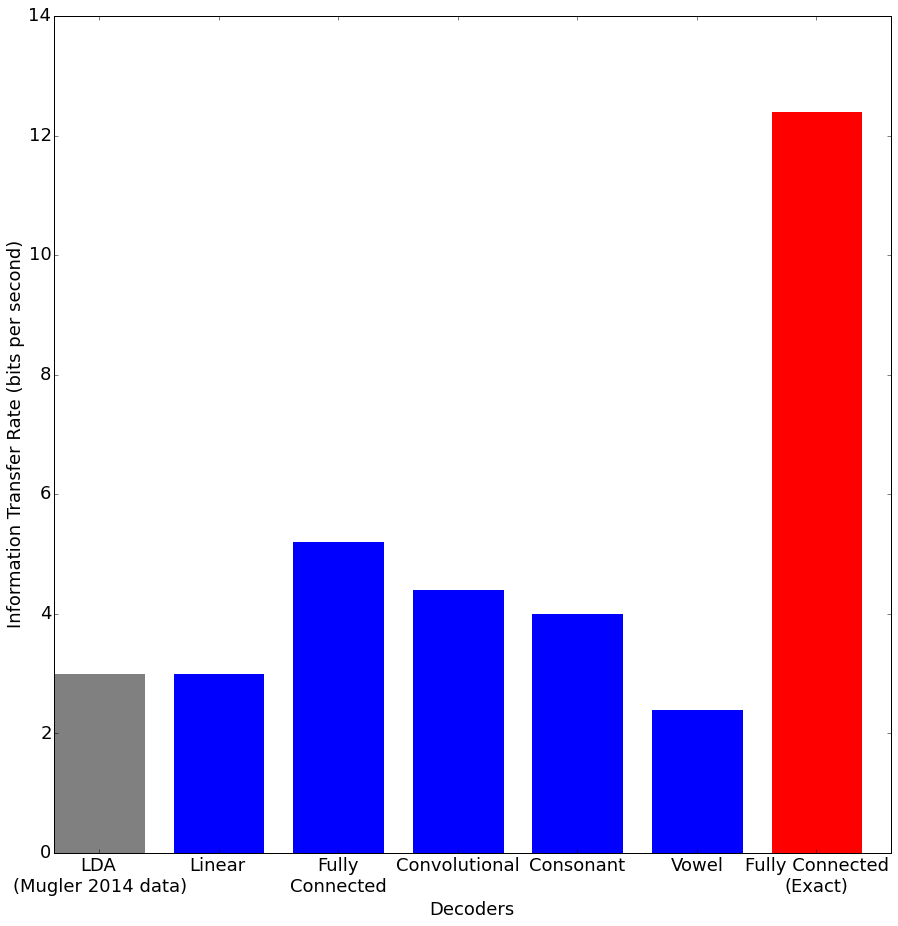

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
rcParams['font.size'] = 18
N = 7
ITR = (3, 3, 5.2, 4.4, 4, 2.4, 12.4)
colors = ('gray', 'b', 'b', 'b', 'b', 'b', 'r')

ind = np.arange(N)  # the x locations for the groups
width = 0.75       # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(ind, ITR, width, color='r')
for rect, c in zip(rects, colors):
    rect.set_color(c)

# add some text for labels, title and axes ticks
ax.set_ylabel('Information Transfer Rate (bits per second)')
ax.set_xlabel('Decoders')
ax.set_xticks(ind+width/2.)
ax.set_xticklabels( ('LDA\n(Mugler 2014 data)', 'Linear', 'Fully\nConnected', 'Convolutional', 'Consonant', 'Vowel', 'Fully Connected\n(Exact)') )
"""
ax.legend( (rects1[0], rects2[0]), ('Men', 'Women') )

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*height, '%d'%int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
"""
plt.show()

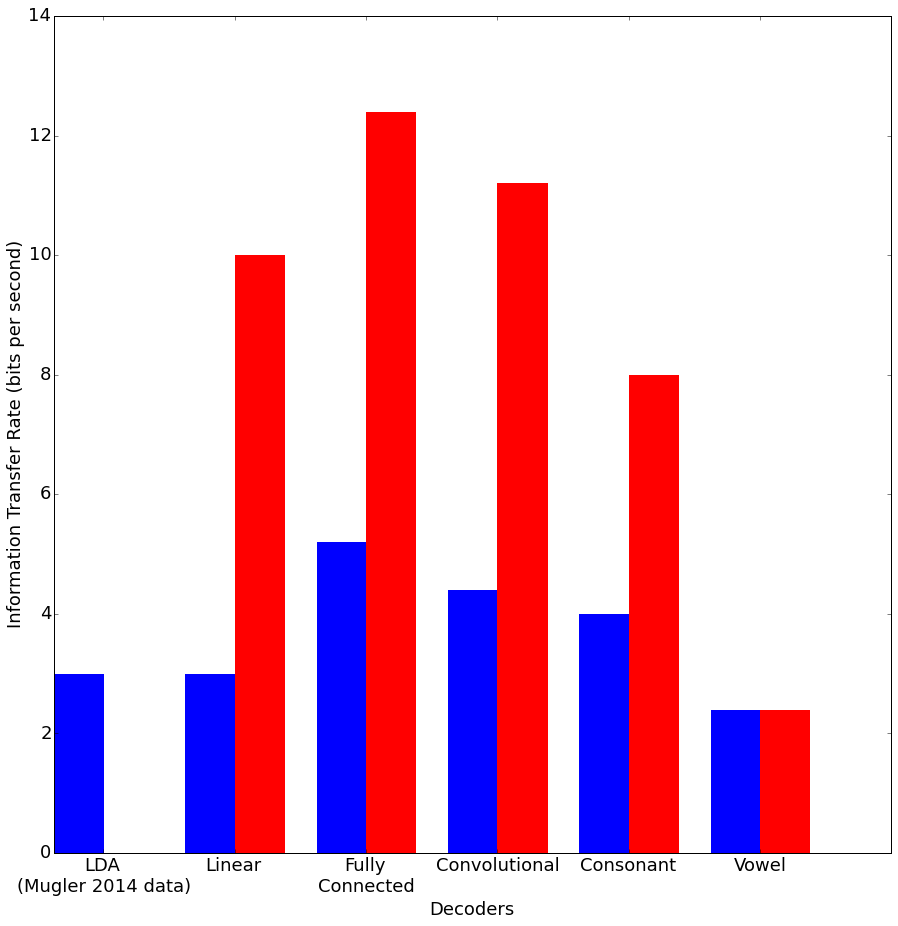

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
rcParams['font.size'] = 18

ITR_mugler = (3,)
ITR_approx = (3, 5.2, 4.4, 4, 2.4)
ITR_exact = (10, 12.4, 11.2, 8, 2.4)
colors = ('gray', 'b', 'b', 'b', 'b', 'b', 'r')

ind = np.arange(N)  # the x locations for the groups
width = 0.75/2.       # the width of the bars

fig, ax = plt.subplots()

rects = ax.bar(np.arange(1), ITR_mugler, width, color='r')
for rect, c in zip(rects, colors):
    rect.set_color('b')
    
rects = ax.bar(np.arange(1,6), ITR_approx, width, color='r')
for rect, c in zip(rects, colors):
    rect.set_color('b')

rects = ax.bar(np.arange(1,6)+width, ITR_exact, width, color='r')
for rect, c in zip(rects, colors):
    rect.set_color('r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Information Transfer (bits per symbol)')
ax.set_xlabel('Decoders')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('LDA\n(Mugler 2014 data)', 'Linear', 'Fully\nConnected', 'Convolutional', 'Consonant', 'Vowel') )
"""
ax.legend( (rects1[0], rects2[0]), ('Men', 'Women') )

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*height, '%d'%int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
"""
plt.show()

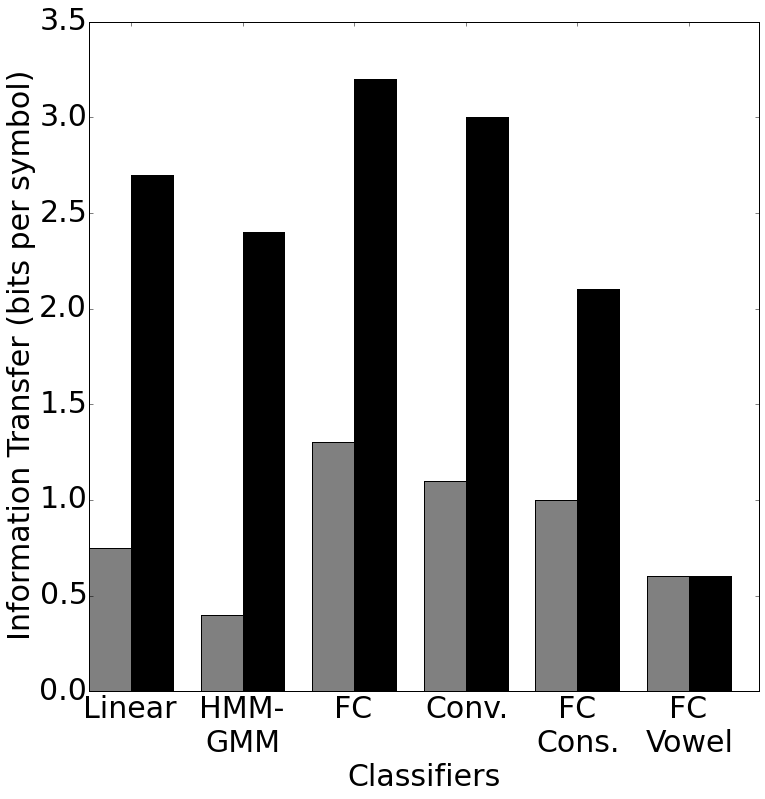

In [92]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 12
rcParams['font.size'] = 30

N = 6
ITR_approx = (.75, .4, 1.3, 1.1, 1.0, .6)
ITR_exact = (2.7, 2.4, 3.2, 3.0, 2.1, .6)

ind = np.arange(N)  # the x locations for the groups
width = 0.75/2.       # the width of the bars

fig, ax = plt.subplots()
    
rects = ax.bar(np.arange(6), ITR_approx, width, color='gray')
#for rect, c in zip(rects, colors):
#    rect.set_color('black')

rects = ax.bar(np.arange(6)+width, ITR_exact, width, color='black')
#for rect, c in zip(rects, colors):
#    rect.set_color('gray')

# add some text for labels, title and axes ticks
ax.set_ylabel('Information Transfer (bits per symbol)')
ax.set_xlabel('Classifiers')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('Linear', 'HMM-\nGMM', 'FC', 'Conv.', 'FC\nCons.', 'FC\nVowel') )
"""
ax.legend( (rects1[0], rects2[0]), ('Men', 'Women') )

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*height, '%d'%int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
"""
plt.savefig('/home/jesse/it.pdf')
plt.show()

In [22]:
ecog_E_lbls

'haa'

## Plot Weights

In [9]:
file_name = '299724_fold7.pkl'
file_loc = os.path.join(model_folder, file_name)
model = serial.load(file_loc)

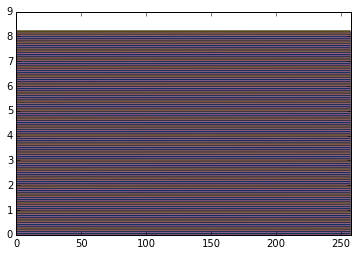

In [30]:
n = 20

filters = np.squeeze(model.get_weights_topo())
x = np.arange(filters.shape[1])
for ii in xrange(filters.shape[0]):
    plt.plot(x, filters[ii].std(axis=1)+5.*ii*filters.std())
plt.xlim([0,258])
plt.show()

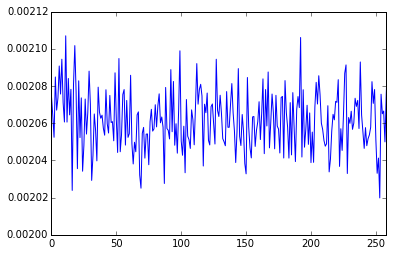

In [34]:
filters = np.squeeze(model.get_weights_topo())
plt.plot(filters.reshape(-1, np.prod(filters.shape[1:])).std(axis=1))
plt.xlim([0,258])
plt.show()